In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from skimage import io
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

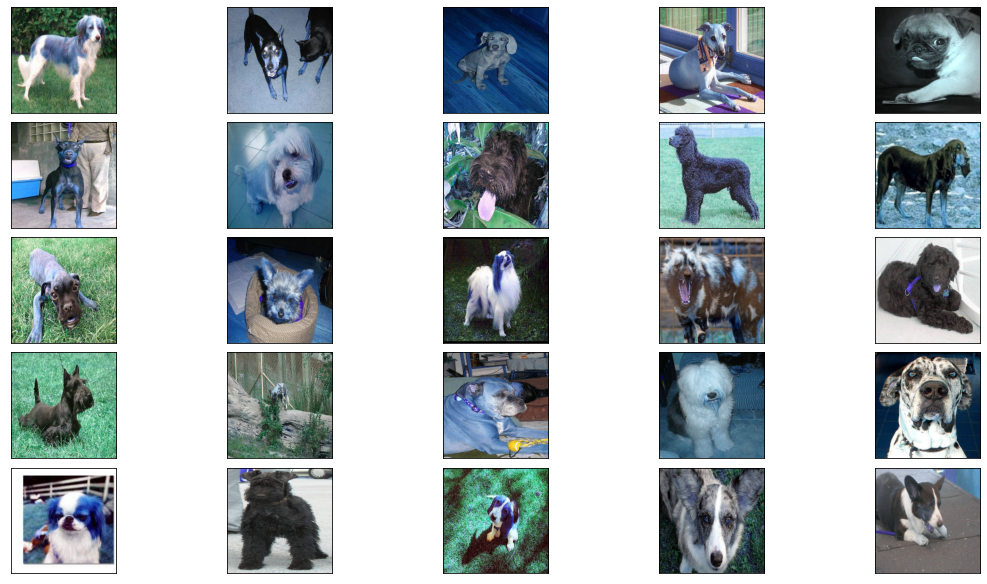

In [2]:
# display first nXm images
def plot_images(rows, columns, images):
    '''
    Plot first 100 images
    INPUTS:
        rows: number of rows we want to display images on it
        columns: number of images we want to display in each row
        images: consist of 100 images each image consist 224*224 pixels
        labels: truth value for each image
    '''
    
    fig, x= plt.subplots(rows, columns, constrained_layout=True,figsize=(15,8))
    plt.setp(x, xticks=[], yticks=[])
    for i in range (len(x)):
        for j in range (len(x[0])):
            index = i*columns+j
            img = cv2.imread('../input/dog-breed-identification/train/' + images[index])
            x[i,j].imshow(cv2.resize(img, (224, 224)))
            
num_columns = 5
train_data = os.listdir('../input/dog-breed-identification/train')[:100]
plot_images(num_columns, num_columns, train_data)

In [3]:
# mapping labels same order of sample_submittion.csv
map_labels = dict()
for index, value in enumerate(pd.read_csv('../input/dog-breed-identification/sample_submission.csv').columns[1:]):
    map_labels[value] = index

In [4]:
# load custom dataset
class DogBreedsDataset_train(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform['train']
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.labels.iloc[index, 0])+'.jpg'
        image = io.imread(img_path)
        y_label = torch.tensor(int(map_labels[self.labels.iloc[index, 1]]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

        
        

In [5]:
# load custom dataset
class DogBreedsDataset_test(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.name_images = pd.read_csv(csv_file)['id'].values
        self.root_dir = root_dir
        self.transform = transform['test']
    
        
    def __len__(self):
        return len(self.name_images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.name_images[index])+'.jpg'
        image = io.imread(img_path)

        if self.transform:
            image = self.transform(image)

        return image

In [6]:
# Hyperparameters
in_channel = 3
num_classes = 120
learning_rate = 1e-4
batch_size = 512
num_epochs = 50

In [7]:
# images preprocessing
transform ={'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(size=256, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])]),  # Imagenet standards
    'test': transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomResizedCrop(size=256, scale=(0.95, 1.0)),
                                      transforms.CenterCrop(size=224),
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])}

dataset = DogBreedsDataset_train('../input/dog-breed-identification/labels.csv', '../input/dog-breed-identification/train', transform)
# Random split data to 70% training and 30% validation
train_set_size = int(len(dataset) * 0.7)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

# loading testing data
test_data = DogBreedsDataset_test('../input/dog-breed-identification/sample_submission.csv', '../input/dog-breed-identification/test', transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [8]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# save checkpoint
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

# load checkpint
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    


In [10]:
# load model architecture with weights (resnet50) 
model = models.resnet50(pretrained=True)

# freeze all layers 
for param in model.parameters():
    param.requires_grad = False
    
# replace last layer with from 1000 classes to be 120 classes
model.fc = nn.Linear(2048, 120)
model = model.to(device=device)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# checkpoint to save and load model
checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}

In [12]:
def traindata(device, model, epochs, optimizer, loss_function, train_loader, valid_loader):
    # Early stopping
    best_loss = 100
    patience = 5
    triggertimes = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        correct = 0
        loss_total = 0
        for data in train_loader:
            input = data[0].to(device)
            label = data[1].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
            loss.backward()
            optimizer.step()
        print('epoch number: {}'.format(epoch))
        print('Training Accuracy: {} Training loss: {}'.format(correct/len(train_loader.sampler), loss_total/len(train_loader)))
        
        # Early stopping
        current_loss = validation(model, device, valid_loader, loss_function)
        print('The Current Loss:', current_loss)
        print('Best Loss:', best_loss)

        if current_loss > best_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0
            save_checkpoint(checkpoint)
            best_loss = current_loss

    return model

In [13]:
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0
    correct = 0
    # Test validation data
    with torch.no_grad():
        for data in valid_loader:
            input = data[0].to(device)
            label = data[1].to(device)

            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
        print('Validation Accuracy: {}'.format(correct/len(valid_loader.sampler)))
    return loss_total / len(valid_loader)

In [14]:
def test(device, model, test_loader, loss_function):

    model.eval()
    predictions = pd.DataFrame()
    with torch.no_grad():
        for data in test_loader:
            input = data.to(device)

            output = model(input)
            m = nn.Softmax(dim=1)
            res = m(output)
            predictions = pd.concat([predictions, pd.DataFrame(torch.Tensor.cpu(res).numpy(), columns = list(map_labels.keys()))], ignore_index=True)
            
        return (predictions)

In [15]:
  model = traindata(device, model, num_epochs, optimizer, criterion, train_loader, valid_loader)

epoch number: 1
Training Accuracy: 0.03214535117149353 Training loss: 4.702834742409842
Validation Accuracy: 0.07433974742889404
The Current Loss: 4.5339508056640625
Best Loss: 100
trigger times: 0
=> Saving checkpoint
epoch number: 2
Training Accuracy: 0.13864430785179138 Training loss: 4.39624115398952
Validation Accuracy: 0.21812847256660461
The Current Loss: 4.267528295516968
Best Loss: 4.5339508056640625
trigger times: 0
=> Saving checkpoint
epoch number: 3
Training Accuracy: 0.33766594529151917 Training loss: 4.118482964379447
Validation Accuracy: 0.41212913393974304
The Current Loss: 4.006074110666911
Best Loss: 4.267528295516968
trigger times: 0
=> Saving checkpoint
epoch number: 4
Training Accuracy: 0.49350103735923767 Training loss: 3.8524673666272844
Validation Accuracy: 0.511248767375946
The Current Loss: 3.7543088595072427
Best Loss: 4.006074110666911
trigger times: 0
=> Saving checkpoint
epoch number: 5
Training Accuracy: 0.5903563499450684 Training loss: 3.59968500477927

In [16]:
load_checkpoint(torch.load("../input/model-29/my_checkpoint.pth.tar"), model, optimizer)

=> Loading checkpoint


In [17]:
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

=> Loading checkpoint


In [18]:
df = test(device, model, test_loader, criterion)
ids = pd.DataFrame(pd.read_csv('../input/dog-breed-identification/sample_submission.csv')['id'].values, columns=['id'])
final_df = pd.concat([ids, df], ignore_index=True, axis=1)
final_df.columns = pd.read_csv('../input/dog-breed-identification/sample_submission.csv').columns

In [19]:
final_df.to_csv('submission.csv', index=False)